<a href="https://colab.research.google.com/github/refiksoyak/MRF/blob/master/Attention_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IN THIS NOTEBOOK, ATTENTION and ITS VARIENTS IMPLEMENTED

In [0]:
import keras
import h5py as h5
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
from sklearn.feature_extraction import image
import numpy as np 
from skimage.util.shape import view_as_windows, view_as_blocks
import skimage.io as io
import skimage.transform as trans
import math
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Using TensorFlow backend.


Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/KCL internship/Task_1/Refik/Notebooks')

In [0]:
from deo import operations

In [0]:
signal_length=2000
skip_size=1

t_type = 'T1' #T1, T2, T1_T2

fold = 1

if fold == 1:
  test = 'kl' #kl, tk, ir, ab, abd
  train1 = 'abd'
  train2 = 'ir'

elif fold == 2:
  test = 'abd' 
  train1 = 'kl'
  train2 = 'ir'

elif fold==3:
  test = 'ir'
  train1 = 'abd'
  train2 = 'kl'


input_shape = 'pixel' #pixel, patch, image
patch_size = 4


In [0]:
signal_ab, T1_ab, T2_ab, signal_tk, T1_tk, T2_tk = operations.read_data('train', fold_number = fold)

In [0]:
signal_ab = operations.handle_complexity(signal_ab)
signal_tk = operations.handle_complexity(signal_tk)

In [0]:
signal_ab = operations.crop_image(signal_ab)
T1_ab = operations.crop_image(T1_ab)
T2_ab = operations.crop_image(T2_ab)

signal_tk = operations.crop_image(signal_tk)
T1_tk = operations.crop_image(T1_tk)
T2_tk = operations.crop_image(T2_tk)

In [0]:
def ext_patch(signal,T1,T2,patch_size):

  signal_patch=[]
  T1_values = image.extract_patches_2d(T1, (patch_size, patch_size))
  T2_values = image.extract_patches_2d(T2, (patch_size, patch_size))
          
  for i in range(signal.shape[2]):
    c_signal=signal[:,:,i]
    signal_patch.append(image.extract_patches_2d(c_signal, (patch_size, patch_size)))
  return np.array(signal_patch), np.array(T1_values), np.array(T2_values)

In [0]:
if input_shape=='pixel':
  
  signal = np.concatenate([signal_ab,signal_tk])
  T1_values = np.concatenate([T1_ab,T1_tk])
  T2_values = np.concatenate([T2_ab,T2_tk])
  signal = signal.reshape(2*220*200,1,signal_length)
  T1_values = T1_values.reshape(2*220*200,1,1)
  T2_values = T2_values.reshape(2*220*200,1,1)
  
elif input_shape=='patch':
  
  #PATCH EXTRACTION
  """
  signal_patch_ab = operations.patch_extracter(signal_ab, patch_size)
  T1_patch_ab = operations.patch_extracter(T1_ab, patch_size)
  T2_patch_ab = operations.patch_extracter(T2_ab, patch_size)
  """
  signal_patch_ab, T1_patch_ab, T2_patch_ab = ext_patch(signal_ab, T1_ab, T2_ab, patch_size)
  signal_patch_ab = np.moveaxis(signal_patch_ab, 0, -1)
  #del signal_ab #delete signal so that is cause use of ram
  """
  signal_patch_tk = operations.patch_extracter(signal_tk, patch_size)
  T1_patch_tk = operations.patch_extracter(T1_tk, patch_size)
  T2_patch_tk = operations.patch_extracter(T2_tk, patch_size)
  """
  signal_patch_tk, T1_patch_tk, T2_patch_tk = ext_patch(signal_tk, T1_tk, T2_tk, patch_size)
  signal_patch_tk = np.moveaxis(signal_patch_tk, 0, -1)
  #del signal_tk #delete signal so that is cause use of ram

  #concatenate of all patients' values before normalization
  signal = np.concatenate((signal_patch_ab, signal_patch_tk)) #t1_tk was removed
  signal = signal.reshape(-1, patch_size, patch_size, 2000)
  del signal_patch_ab, signal_patch_tk
  T1_values=np.concatenate((T1_patch_ab, T1_patch_tk))
  T2_values=np.concatenate((T2_patch_ab, T2_patch_tk))
  del T1_patch_ab, T1_patch_tk, T2_patch_ab, T2_patch_tk

  T1_values = T1_values.reshape(-1, patch_size, patch_size, 1)
  T2_values = T2_values.reshape(-1, patch_size, patch_size, 1)
else:
  print('Wrong input shape')
  
print('Signal shape:',signal.shape)
print('T1_values shape:', T1_values.shape)
print('T2_values shape:', T2_values.shape)


Signal shape: (88000, 1, 2000)
T1_values shape: (88000, 1, 1)
T2_values shape: (88000, 1, 1)


In [0]:
#normalize data
T1_values = operations.normalize(T1_values)
T2_values = operations.normalize(T2_values)
signal = operations.normalize(signal)

In [0]:
#Defining output (target)
if t_type == 'T1':
  
  T_val = T1_values
  models_output_size = 1

elif t_type == 'T2':

  T_val = T2_values
  models_output_size = 1

elif t_type == 'T1_T2':
  if input_shape == 'patch': axis = 3
  elif input_shape == 'pixel': axis = 2
  T_val = np.concatenate([T1_values,T2_values], axis = axis)
  models_output_size = 2
else:
  print('Wrong t_type! Enter T1,T2 or T1_T2')

In [0]:
#Models 
def dense():

  inputs = keras.Input((patch_size, patch_size, 2000))
  x = keras.layers.Dense(128,activation='relu',name='dense1')(inputs)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(64,activation='relu',name='dense2')(x)
  #x = keras.layers.BatchNormalization()(x)
  #x = keras.layers.Dense(32,activation='relu',name='dense3')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(16,activation='relu',name='dense4')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(1, name='dense5')(x)

  model = keras.models.Model(inputs = inputs, outputs = x)
  return model

#1D models

def conv1D(spatial_attention = False, channel_attention = False):
  inputs = keras.Input((1, 2000))
  
  x = keras.layers.Conv1D(32, 3, padding = 'same')(inputs)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv1D(64, 3, padding = 'same')(x)
  x = keras.layers.Activation('relu')(x)

  if channel_attention:
    x = channel_attn_1D(x, 64, 4 )

  if spatial_attention:
    x = spatial_attn_1D(x, 64) #Spatial attention

  x = keras.layers.Conv1D(128, 3, padding = 'same')(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv1D(64, 3, padding = 'same')(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Dense(1, activation='relu')(x)

  return keras.models.Model(inputs = inputs, outputs = x)


def spatial_attn_1D(x, nb_filter):
  
  avg_pl = keras.layers.AveragePooling1D(pool_size=1)(x)
  max_pl = keras.layers.MaxPooling1D(pool_size=1)(x)
  conc = keras.layers.concatenate([avg_pl, max_pl])
  conc = keras.layers.Conv1D(nb_filter, 5, padding='same')(conc)
  conc = keras.layers.Activation('sigmoid')(conc)
  sa = keras.layers.multiply([x, conc])
  return sa

def channel_attn_1D(x, nb_filter, reduction = 4):

  avg_pl = keras.layers.AveragePooling1D(pool_size=1)(x)
  avg_pl = keras.layers.Activation('relu')(avg_pl)

  max_pl = keras.layers.MaxPooling1D(pool_size=1)(x)
  max_pl = keras.layers.Activation('relu')(max_pl)

  dense1 = keras.layers.Dense(nb_filter//reduction)
  dense2 = keras.layers.Dense(nb_filter)

  avg_pl_out = dense1(avg_pl)
  avg_pl_out = dense2(avg_pl_out)

  max_pl_out = dense1(max_pl)
  max_pl_out = dense2(max_pl_out)

  ca = keras.layers.add([avg_pl_out, max_pl_out])
  ca = keras.layers.Activation('sigmoid')(ca)

  return keras.layers.multiply([x, ca])





#2D models
def lstm2D():
  inputs = keras.Input((patch_size, patch_size, 2000))
  x = keras.layers.TimeDistributed(keras.layers.LSTM(128, return_sequences=True))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.TimeDistributed(keras.layers.LSTM(64, return_sequences=True))(x)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.TimeDistributed(keras.layers.LSTM(16, return_sequences=True))(x)
  x = keras.layers.Dense(2, activation='relu')(x)
  
  model = keras.models.Model(inputs = inputs, outputs = x)
  #Total params: 1,145,425
  return model

def conv2D(spatial_attention = False, channel_attention = False):
  inputs = keras.Input((patch_size, patch_size, 2000))
  
  #x = channel_attn_2D(inputs, 2000, 62 )
  x = keras.layers.Conv2D(32, 3, padding = 'same')(inputs)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
  x = keras.layers.Activation('relu')(x)

  if channel_attention:
    x = channel_attn_2D(x, 64, 4 )

  if spatial_attention:
    x = spatial_attn_2D(x, 64) #Spatial attention


  x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
  x = keras.layers.Activation('relu')(x)
 
  
  x = keras.layers.Dense(2, activation = 'relu')(x)

  return keras.models.Model(inputs = inputs, outputs = x)

def spatial_attn_2D(x, nb_filter):
  
  avg_pl = keras.layers.AveragePooling2D(pool_size=patch_size)(x)
  max_pl = keras.layers.MaxPooling2D(pool_size=patch_size)(x)
  conc = keras.layers.concatenate([avg_pl, max_pl])
  conc = keras.layers.Conv2D(nb_filter, 3, padding='same')(conc)
  conc = keras.layers.Activation('sigmoid')(conc)
  sa = keras.layers.multiply([x, conc])
  return sa

def channel_attn_2D(x, nb_filter, reduction = 4):

  avg_pl = keras.layers.AveragePooling2D(pool_size=patch_size)(x)
  avg_pl = keras.layers.Activation('relu')(avg_pl)

  max_pl = keras.layers.MaxPooling2D(pool_size=patch_size)(x)
  max_pl = keras.layers.Activation('relu')(max_pl)

  dense1 = keras.layers.Dense(nb_filter//reduction)
  dense2 = keras.layers.Dense(nb_filter)

  avg_pl_out = dense1(avg_pl)
  avg_pl_out = dense2(avg_pl_out)

  max_pl_out = dense1(max_pl)
  max_pl_out = dense2(max_pl_out)

  ca = keras.layers.add([avg_pl_out, max_pl_out])
  ca = keras.layers.Activation('sigmoid')(ca)

  return keras.layers.multiply([x, ca])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2000)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             192032    
_________________________________________________________________
activation_1 (Activation)    (None, 1, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             6208      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            24704     
_________________________________________________________________
activation_3 (Activation)    (None, 1, 128)            0   

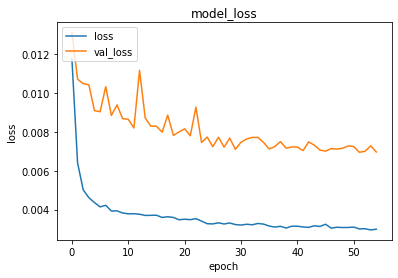

In [0]:
#Train a model
model = conv1D()
model_name = t_type + '_' + input_shape + '_' + 'conv1D' +'_'+ test

lr = 0.0015
decay = 0
batch_size = 600
num_epoch = 100

model.compile(optimizer = keras.optimizers.adam(lr = lr, decay = decay),loss='mean_squared_error', metrics=['mean_absolute_error']) #fe_lr
model.summary()

filepath='/content/drive/My Drive/KCL internship/Task_1/Refik/fixed_lr_models/'+ model_name +'.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='auto')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='auto', patience=15, verbose=1)
callbacks_list = [checkpoint, earlystopping]

hist = model.fit(signal, T_val, validation_split = 0.3, epochs = num_epoch, batch_size = batch_size, callbacks=callbacks_list) 

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

In [0]:
"""#Load the model
from keras.models import load_model

model_name = t_type + '_' + input_shape + '_' + 'conv2D_ca_2000' +'_'+ test
filepath='/content/drive/My Drive/KCL internship/Task_1/Refik/fixed_lr_models/'+ model_name +'.hdf5'

model = load_model(filepath)
model.summary()

#Pop the layers till attention score layer
attn_sroce_model = keras.models.Model(input = model.inputs, outputs = model.get_layer(index=8).output) 
attn_sroce_model.summary()

#Make prediction to get attention values
attn_score = attn_sroce_model.predict(signal)
print("attn shape:", attn_score.shape)"""

'#Load the model\nfrom keras.models import load_model\n\nmodel_name = t_type + \'_\' + input_shape + \'_\' + \'conv2D_ca_2000\' +\'_\'+ test\nfilepath=\'/content/drive/My Drive/KCL internship/Task_1/Refik/fixed_lr_models/\'+ model_name +\'.hdf5\'\n\nmodel = load_model(filepath)\nmodel.summary()\n\n#Pop the layers till attention score layer\nattn_sroce_model = keras.models.Model(input = model.inputs, outputs = model.get_layer(index=8).output) \nattn_sroce_model.summary()\n\n#Make prediction to get attention values\nattn_score = attn_sroce_model.predict(signal)\nprint("attn shape:", attn_score.shape)'

In [0]:
"""#Visualize region and its channel attention analysis
fig=plt.figure(figsize=(25, 7))
fig.suptitle("Channel Attention Analysis", fontsize=20)

if input_shape == 'pixel':

  attn_score_ab = attn_score[0:44000, :, :]
  attn_score_ab_im = attn_score_ab.reshape(220, 200, 2000)

  attn_score_tk = attn_score[44000: 88000, :, :]
  
  #print("attn_score_ab:",attn_score_ab.shape)

  pixel = 113
  attn_score_ab_over_channel = attn_score_ab_over_channel.reshape(-1,1)
  attn_score_ab_over_channel = attn_score_ab_im[pixel, pixel, :]
  #print("attn_score_ab_im_pix0 shape:",attn_score_ab_im_pix.shape)

  T1_ab_pix_remarked = np.copy(T1_ab)
  T1_ab_pix_remarked[pixel, pixel] = np.max(T1_ab)*3

  plt.annotate("", xy=(pixel-1, pixel-1), xytext=(pixel-15, pixel-15),
            arrowprops=dict(width = 5.,
                             headwidth = 15.,
                            headlength = 5,
                            shrink = 0.05,
                            linewidth = 2, color = 'cyan'))

  plt.subplot(1,2,2)
  plt.plot(attn_score_tk_over_channel)

  plt.title("["+str(pixel)+","+str(pixel)+"]" + " pixel's attention scores for each channel")
  plt.margins(0, 0)
  plt.show()
  
    
elif input_shape == 'patch':
  
  attn_score_ab_over_channel = attn_score[0:42749, :, :, :]
  attn_score_ab_over_channel = attn_score_ab_over_channel.reshape(-1, attn_score_ab_over_channel.shape[3])

  attn_score_tk_over_channel = attn_score[42749: 85498, :, :, :]
  attn_score_tk_over_channel = attn_score_tk_over_channel.reshape(-1, attn_score_tk_over_channel.shape[3])
  

  patch = 22000
  max_patch_for_a_row = (200-(patch_size - 1))
  patch_row = patch//max_patch_for_a_row
  patch_col = patch%(max_patch_for_a_row)
  #print("patch_row:"+ str(patch_row)+ " patch_col:"+ str(patch_col))

  plt.subplot(1, 2, 1)
  plt.imshow(T1_ab, vmin=0, vmax=6000)
  rectangle = plt.Rectangle((patch_col, patch_row), patch_size, patch_size, linewidth=3, edgecolor='r', facecolor='none')

  plt.gca().add_patch(rectangle)
  plt.colorbar()


  plt.subplot(1, 2, 2)
  plt.plot(attn_score_ab_over_channel[patch])

  plt.title(str(patch)+"th patch attention scores for each channel")
  plt.margins(0, 0)
  """

'#Visualize region and its channel attention analysis\nfig=plt.figure(figsize=(25, 7))\nfig.suptitle("Channel Attention Analysis", fontsize=20)\n\nif input_shape == \'pixel\':\n\n  attn_score_ab = attn_score[0:44000, :, :]\n  attn_score_ab_im = attn_score_ab.reshape(220, 200, 2000)\n\n  attn_score_tk = attn_score[44000: 88000, :, :]\n  \n  #print("attn_score_ab:",attn_score_ab.shape)\n\n  pixel = 113\n  attn_score_ab_over_channel = attn_score_ab_over_channel.reshape(-1,1)\n  attn_score_ab_over_channel = attn_score_ab_im[pixel, pixel, :]\n  #print("attn_score_ab_im_pix0 shape:",attn_score_ab_im_pix.shape)\n\n  T1_ab_pix_remarked = np.copy(T1_ab)\n  T1_ab_pix_remarked[pixel, pixel] = np.max(T1_ab)*3\n\n  plt.annotate("", xy=(pixel-1, pixel-1), xytext=(pixel-15, pixel-15),\n            arrowprops=dict(width = 5.,\n                             headwidth = 15.,\n                            headlength = 5,\n                            shrink = 0.05,\n                            linewidth = 2